In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "5"

isola-h100-1.csail.mit.edu
/vision-nfs/isola/env/akumar01/synthetic-mdps/src
/vision-nfs/isola/env/akumar01/.virtualenvs/smdps/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [54]:
envs = ["Reacher", "InvertedPendulum", "InvertedDoublePendulum", "HalfCheetah", "Hopper", "Swimmer", "Walker2d", "Ant"]
envs = ["Reacher", "InvertedPendulum", "InvertedDoublePendulum", "HalfCheetah", "Hopper", "Walker2d", "Ant"]
hmds = [32, 64, 128, 256, 512, 1024, 2048, 4096]

rets_oracle = {
    "Reacher": -3.91,
    "InvertedPendulum": 830,
    "InvertedDoublePendulum": 5840,
    "HalfCheetah": 5110,
    "Hopper": 2140,
    "Swimmer": 137,
    "Walker2d": 4275,
    "Ant": 3760
}


  0%|          | 0/8 [00:00<?, ?it/s]

Reacher 32
Reacher 64
Reacher 128
Reacher 256
Reacher 512
Reacher 1024
Reacher 2048
Reacher 4096


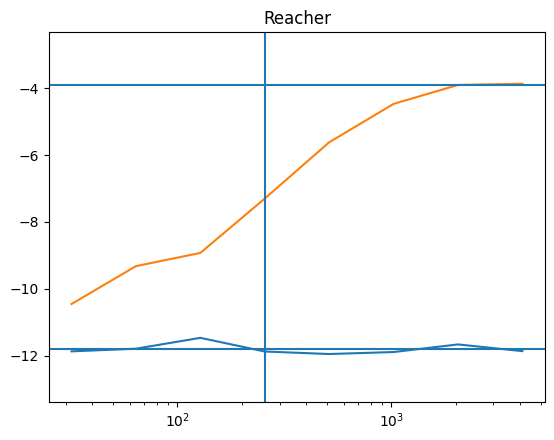

  0%|          | 0/8 [00:00<?, ?it/s]

InvertedPendulum 32
InvertedPendulum 64
InvertedPendulum 128
InvertedPendulum 256
InvertedPendulum 512
InvertedPendulum 1024
InvertedPendulum 2048
InvertedPendulum 4096


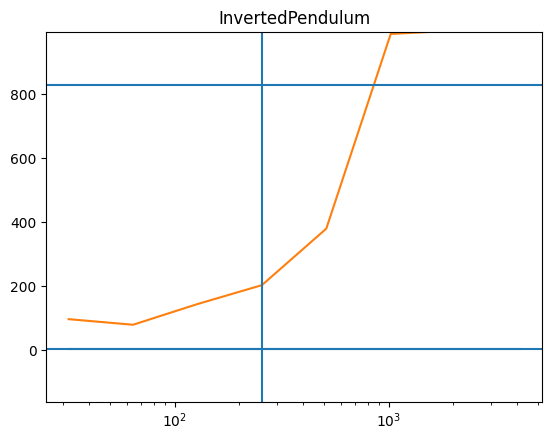

  0%|          | 0/8 [00:00<?, ?it/s]

InvertedDoublePendulum 32
InvertedDoublePendulum 64
InvertedDoublePendulum 128
InvertedDoublePendulum 256
InvertedDoublePendulum 512
InvertedDoublePendulum 1024
InvertedDoublePendulum 2048
InvertedDoublePendulum 4096


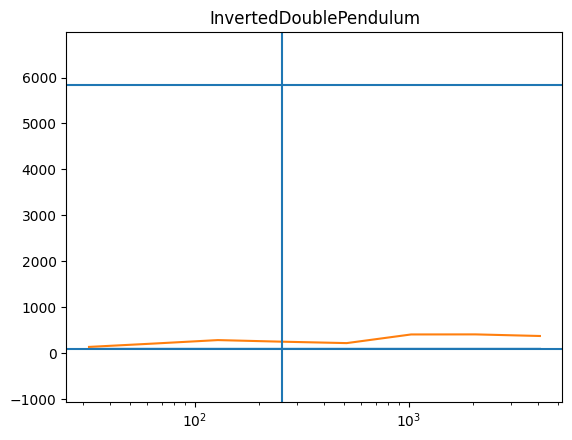

  0%|          | 0/8 [00:00<?, ?it/s]

HalfCheetah 32
HalfCheetah 64
HalfCheetah 128
HalfCheetah 256
HalfCheetah 512
HalfCheetah 1024
HalfCheetah 2048
HalfCheetah 4096


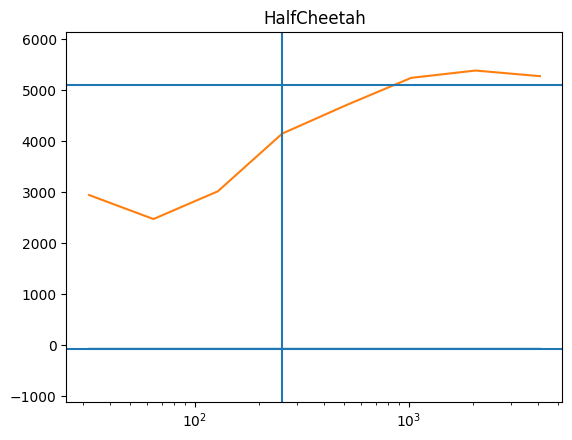

  0%|          | 0/8 [00:00<?, ?it/s]

Hopper 32
Hopper 64
Hopper 128
Hopper 256
Hopper 512
Hopper 1024
Hopper 2048
Hopper 4096


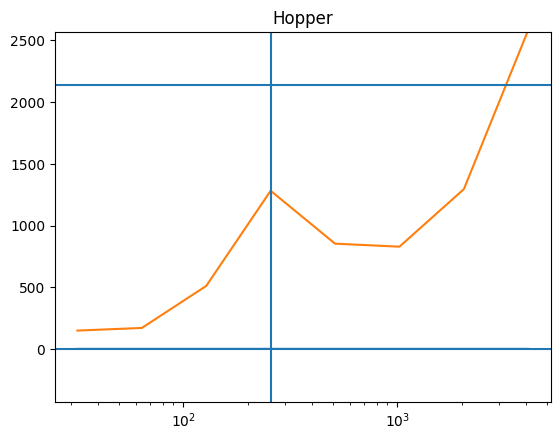

  0%|          | 0/8 [00:00<?, ?it/s]

Walker2d 32
Walker2d 64
Walker2d 128
Walker2d 256
Walker2d 512
Walker2d 1024
Walker2d 2048
Walker2d 4096


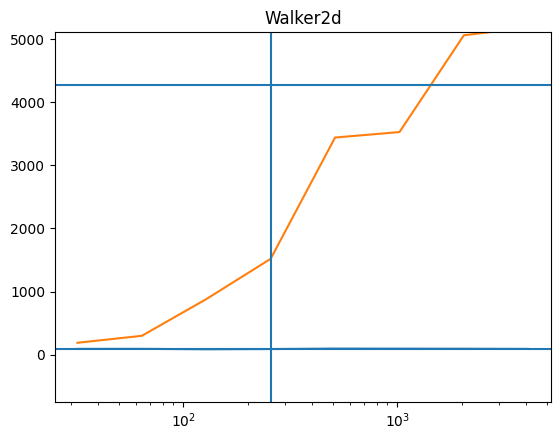

  0%|          | 0/8 [00:00<?, ?it/s]

Ant 32
Ant 64
Ant 128
Ant 256
Ant 512
Ant 1024
Ant 2048
Ant 4096


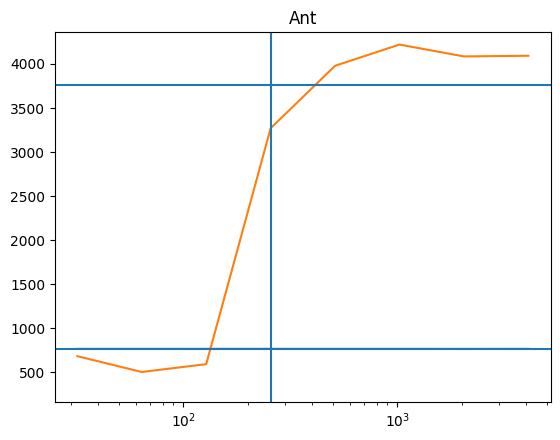

In [55]:
for env in envs:
    rets = []
    for hmd in tqdm(hmds):
        print(env, hmd)
        with open(f"/vision-nfs/isola/env/akumar01/synthetic-mdps-data/how_much_data/{env}_{hmd}/scratch/rollout_data.pkl", "rb") as f:
            a = pickle.load(f)
        rets.append([a[0]['rets'].mean(), a[-1]['rets'].mean()])
    rets = np.array(rets)
    plt.plot(hmds, rets[:, 0])
    plt.plot(hmds, rets[:, 1])

    a = (rets_oracle[env]-rets[:, 0].mean())*.2
    plt.ylim(rets[:, 0].mean()-a, rets_oracle[env]+a)
    plt.axhline(rets[:, 0].mean())
    plt.axhline(rets_oracle[env])
    
    plt.axvline(256)
    plt.xscale('log')
    plt.title(env)
    plt.show()

In [4]:
from util import load_pkl
from compile_experiment import envs_mujoco, envs_synthetic

45
name=csmdp;i_d=0;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=1;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=3;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=4;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=0;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=1;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=3;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=4;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=2;t_a=0;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=2;t_a=1;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=2;t_a=2;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
name=csmdp;i_d=2;i_s=2;t_a=3;t_c=2;t_l=2;t_s=2;o_d=2;o_c=2;r_c=2;tl=64
nam

In [5]:
from collections import defaultdict

In [6]:
import xarray as xr

In [130]:
oracle_rets = {
    "Reacher": -3.91,
    "InvertedPendulum": 830,
    "InvertedDoublePendulum": 5840,
    "HalfCheetah": 5110,
    "Hopper": 2140,
    "Walker2d": 4275,
    "Ant": 3760
}

In [131]:
oracle_rets = pd.Series(oracle_rets)

In [132]:
data = defaultdict(lambda: defaultdict(dict))

for env in envs_mujoco:
    for env_syn in tqdm(envs_synthetic+['scratch']):
        if env_syn in envs_synthetic:
            env_load_name = f"{env_syn}_oracle_aug"
        else:
            env_load_name = env_syn
            
        a = load_pkl(f"/vision-nfs/isola/env/akumar01/synthetic-mdps-data/icl_test/{env}/{env_load_name}", "metrics_test")
        data['mse_act_before'][env][env_syn] = a['mse_act'][0, :].mean().item()
        data['mse_act_after'][env][env_syn] = a['mse_act'][-1, :].mean().item()
        data['mse_obs_before'][env][env_syn] = a['mse_obs'][0, :].mean().item()
        data['mse_obs_after'][env][env_syn] = a['mse_obs'][-1, :].mean().item()
        
        a = load_pkl(f"/vision-nfs/isola/env/akumar01/synthetic-mdps-data/icl_test/{env}/{env_load_name}", "rollout_data")        
        data['rets_before_mean'][env][env_syn] = a[0]['rets'].mean().item()
        data['rets_before_std'][env][env_syn] = a[0]['rets'].std().item()/8
        data['rets_after_mean'][env][env_syn] = a[-1]['rets'].mean().item()
        data['rets_after_std'][env][env_syn] = a[-1]['rets'].std().item()/8


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

In [133]:
dfs = {k: pd.DataFrame(v) for k, v in data.items()}

In [134]:
dfs['rets_before_mean_norm'] = (dfs['rets_before_mean']-scratch_rets)/(oracle_rets-scratch_rets)
dfs['rets_after_mean_norm'] = (dfs['rets_after_mean']-scratch_rets)/(oracle_rets-scratch_rets)

In [135]:
for k in dfs:
    dfs[k]['aggregate'] = dfs[k].mean(axis=1)

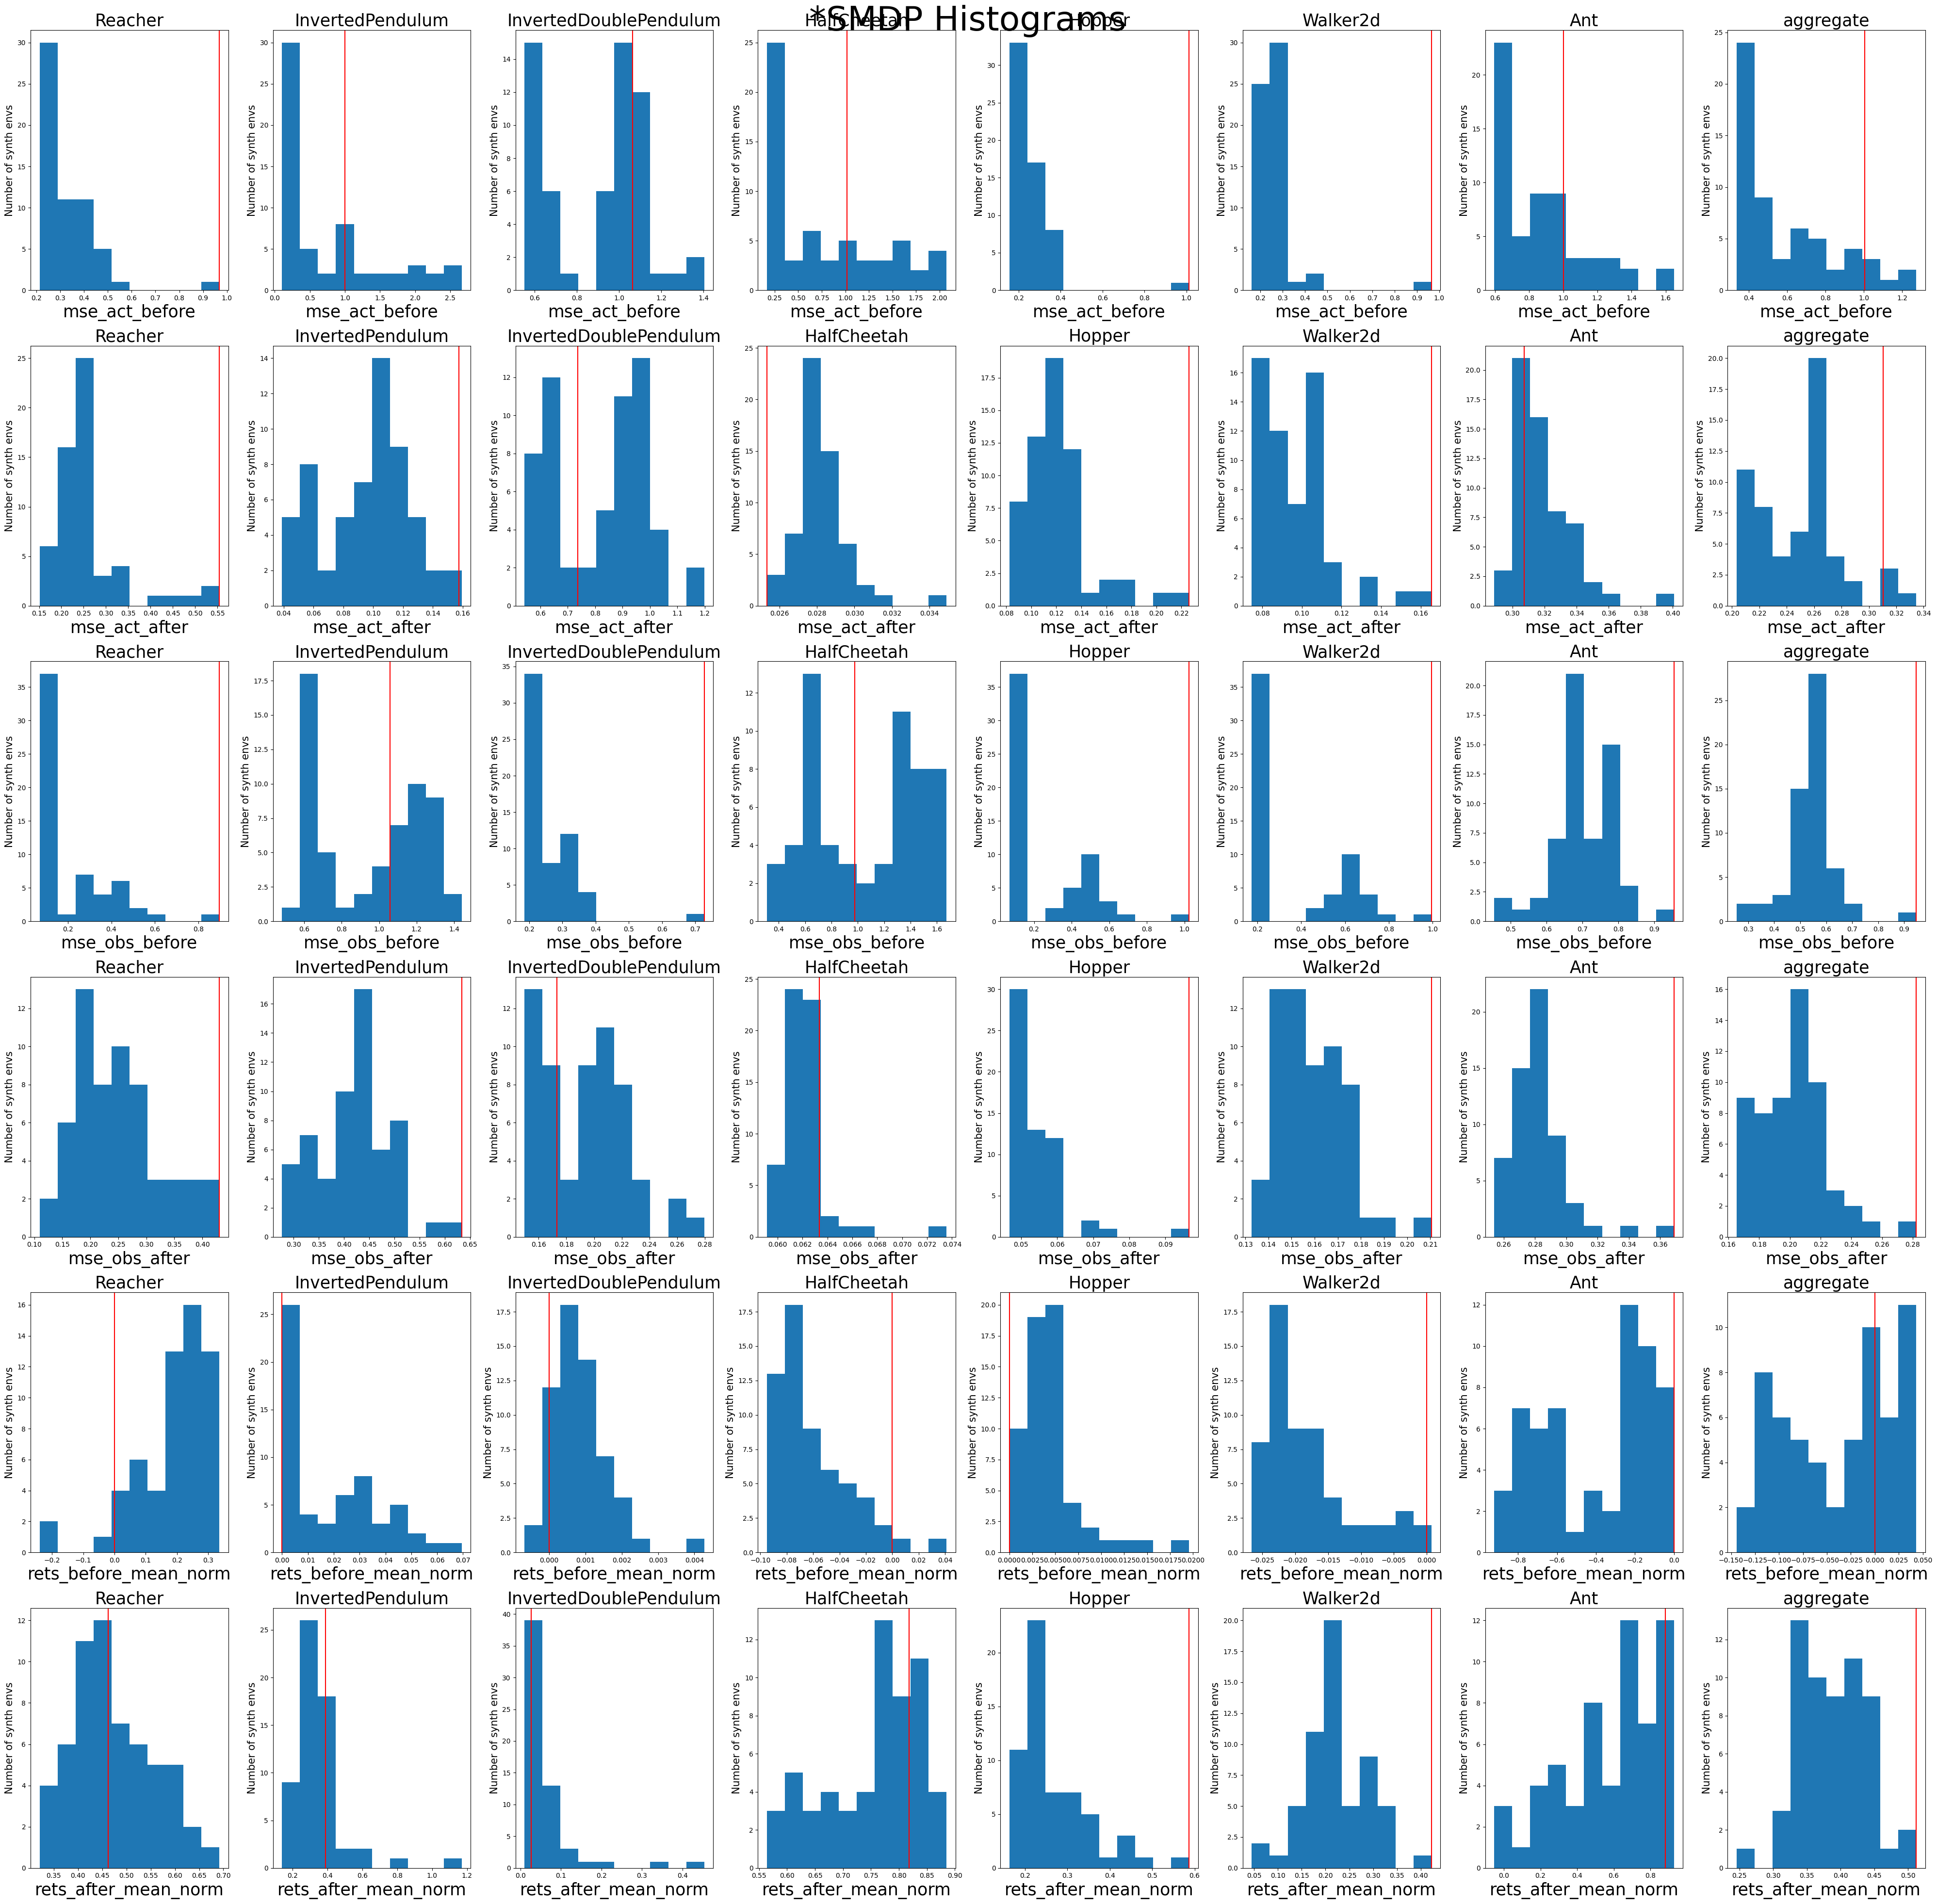

In [137]:
plt.figure(figsize=(40, 40))
i_plt = 0
metrics = ['mse_act_before', 'mse_act_after', 'mse_obs_before', 'mse_obs_after', 'rets_before_mean_norm', 'rets_after_mean_norm']
for metric in metrics:
    for env in envs_mujoco+['aggregate']:
        i_plt += 1
        plt.subplot(len(metrics), len(envs_mujoco)+1, i_plt)
        plt.title(env, fontsize=25)
        plt.hist(dfs[metric].loc[:, env])
        plt.axvline(dfs[metric].loc['scratch', env], c='r')
        plt.xlabel(metric, fontsize=25)
        plt.ylabel("Number of synth envs", fontsize=15)
plt.suptitle("*SMDP Histograms", fontsize=50)
plt.tight_layout()

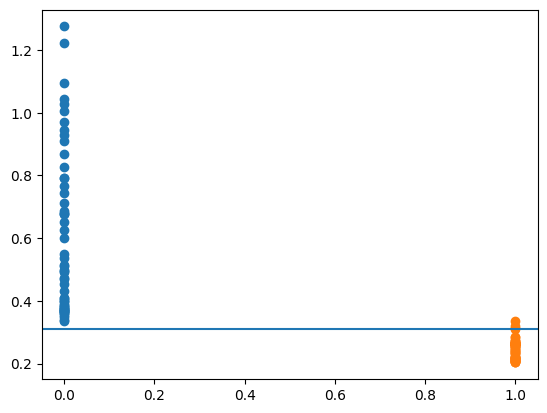

In [98]:
plt.scatter(np.zeros(59), dfs['mse_act_before']['aggregate'])
plt.scatter(np.ones(59), dfs['mse_act_after']['aggregate'])
plt.axhline(dfs['mse_act_after']['aggregate']['scratch'])

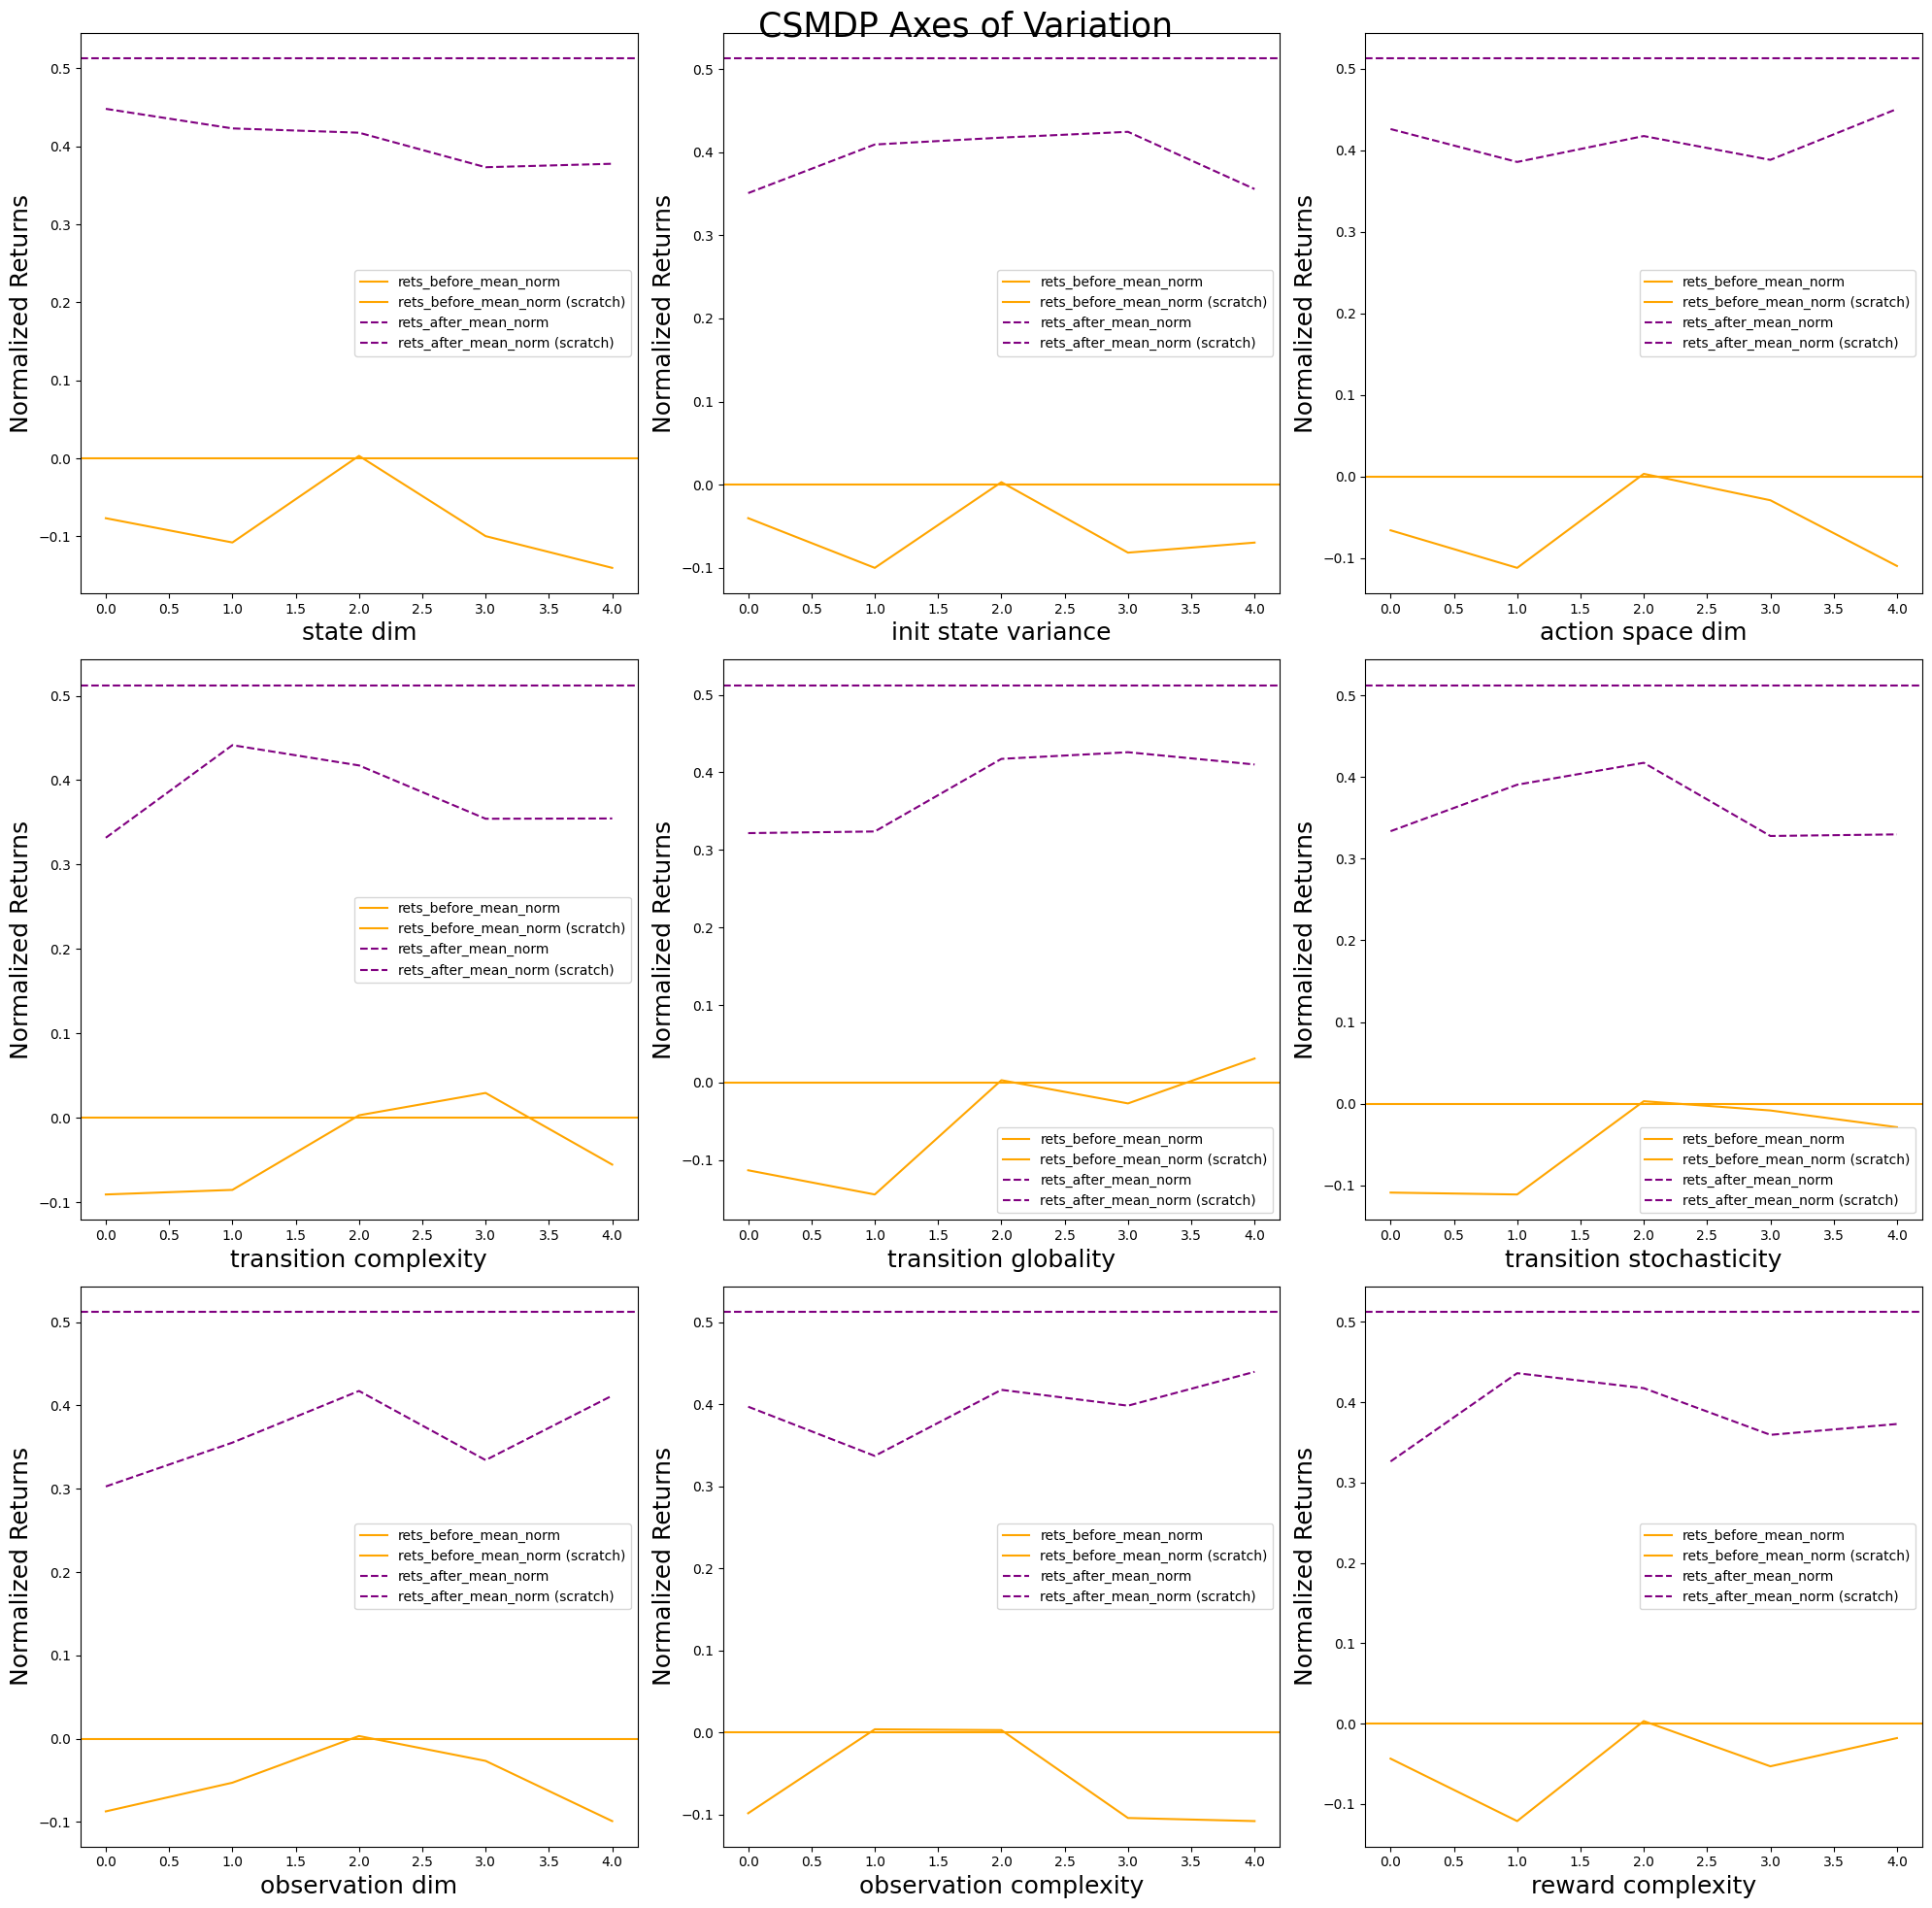

In [129]:
env_args_default = dict(i_d=2,i_s=2,t_a=2,t_c=2,t_l=2,t_s=2,o_d=2,o_c=2,r_c=2,tl=64)

arg2title = dict(i_d="state dim", i_s="init state variance", t_a="action space dim", t_c="transition complexity",
                 t_l="transition globality", t_s="transition stochasticity", o_d="observation dim", o_c="observation complexity", r_c="reward complexity")

plt.figure(figsize=(20, 20))
for i_plt, k in enumerate(env_args_default):
    if k=='tl':
        continue
    env_args = env_args_default.copy()
    env_ids = []
    for i in range(5):
        env_args[k] = i
        env_id = "name=csmdp;"+";".join([f"{k}={v}" for k, v in env_args.items()])
        env_ids.append(env_id)

    # metrics = ['mse_act_before', 'mse_act_after', 'mse_obs_before', 'mse_obs_after']
    # cs = ['g', 'g', 'b', 'b']
    # linestyles = ['solid', '--', 'solid', '--']

    metrics = ['rets_before_mean_norm', 'rets_after_mean_norm']
    cs = ['orange', 'purple']
    linestyles = ['solid', '--']

    plt.subplot(3, 3, i_plt+1)
    for metric, c, ls in zip(metrics, cs, linestyles):
        plt.plot(np.arange(5), list(dfs[metric]['aggregate'].loc[env_ids]), c=c, linestyle=ls, label=metric)
    
        plt.axhline(dfs[metric]['aggregate'].loc['scratch'], c=c, linestyle=ls, label=f'{metric} (scratch)')
        
    plt.legend()
    plt.xlabel(arg2title[k], fontsize=18)
    plt.ylabel("Normalized Returns", fontsize=18)

plt.suptitle("CSMDP Axes of Variation", fontsize=25)
plt.tight_layout()
plt.show()
    

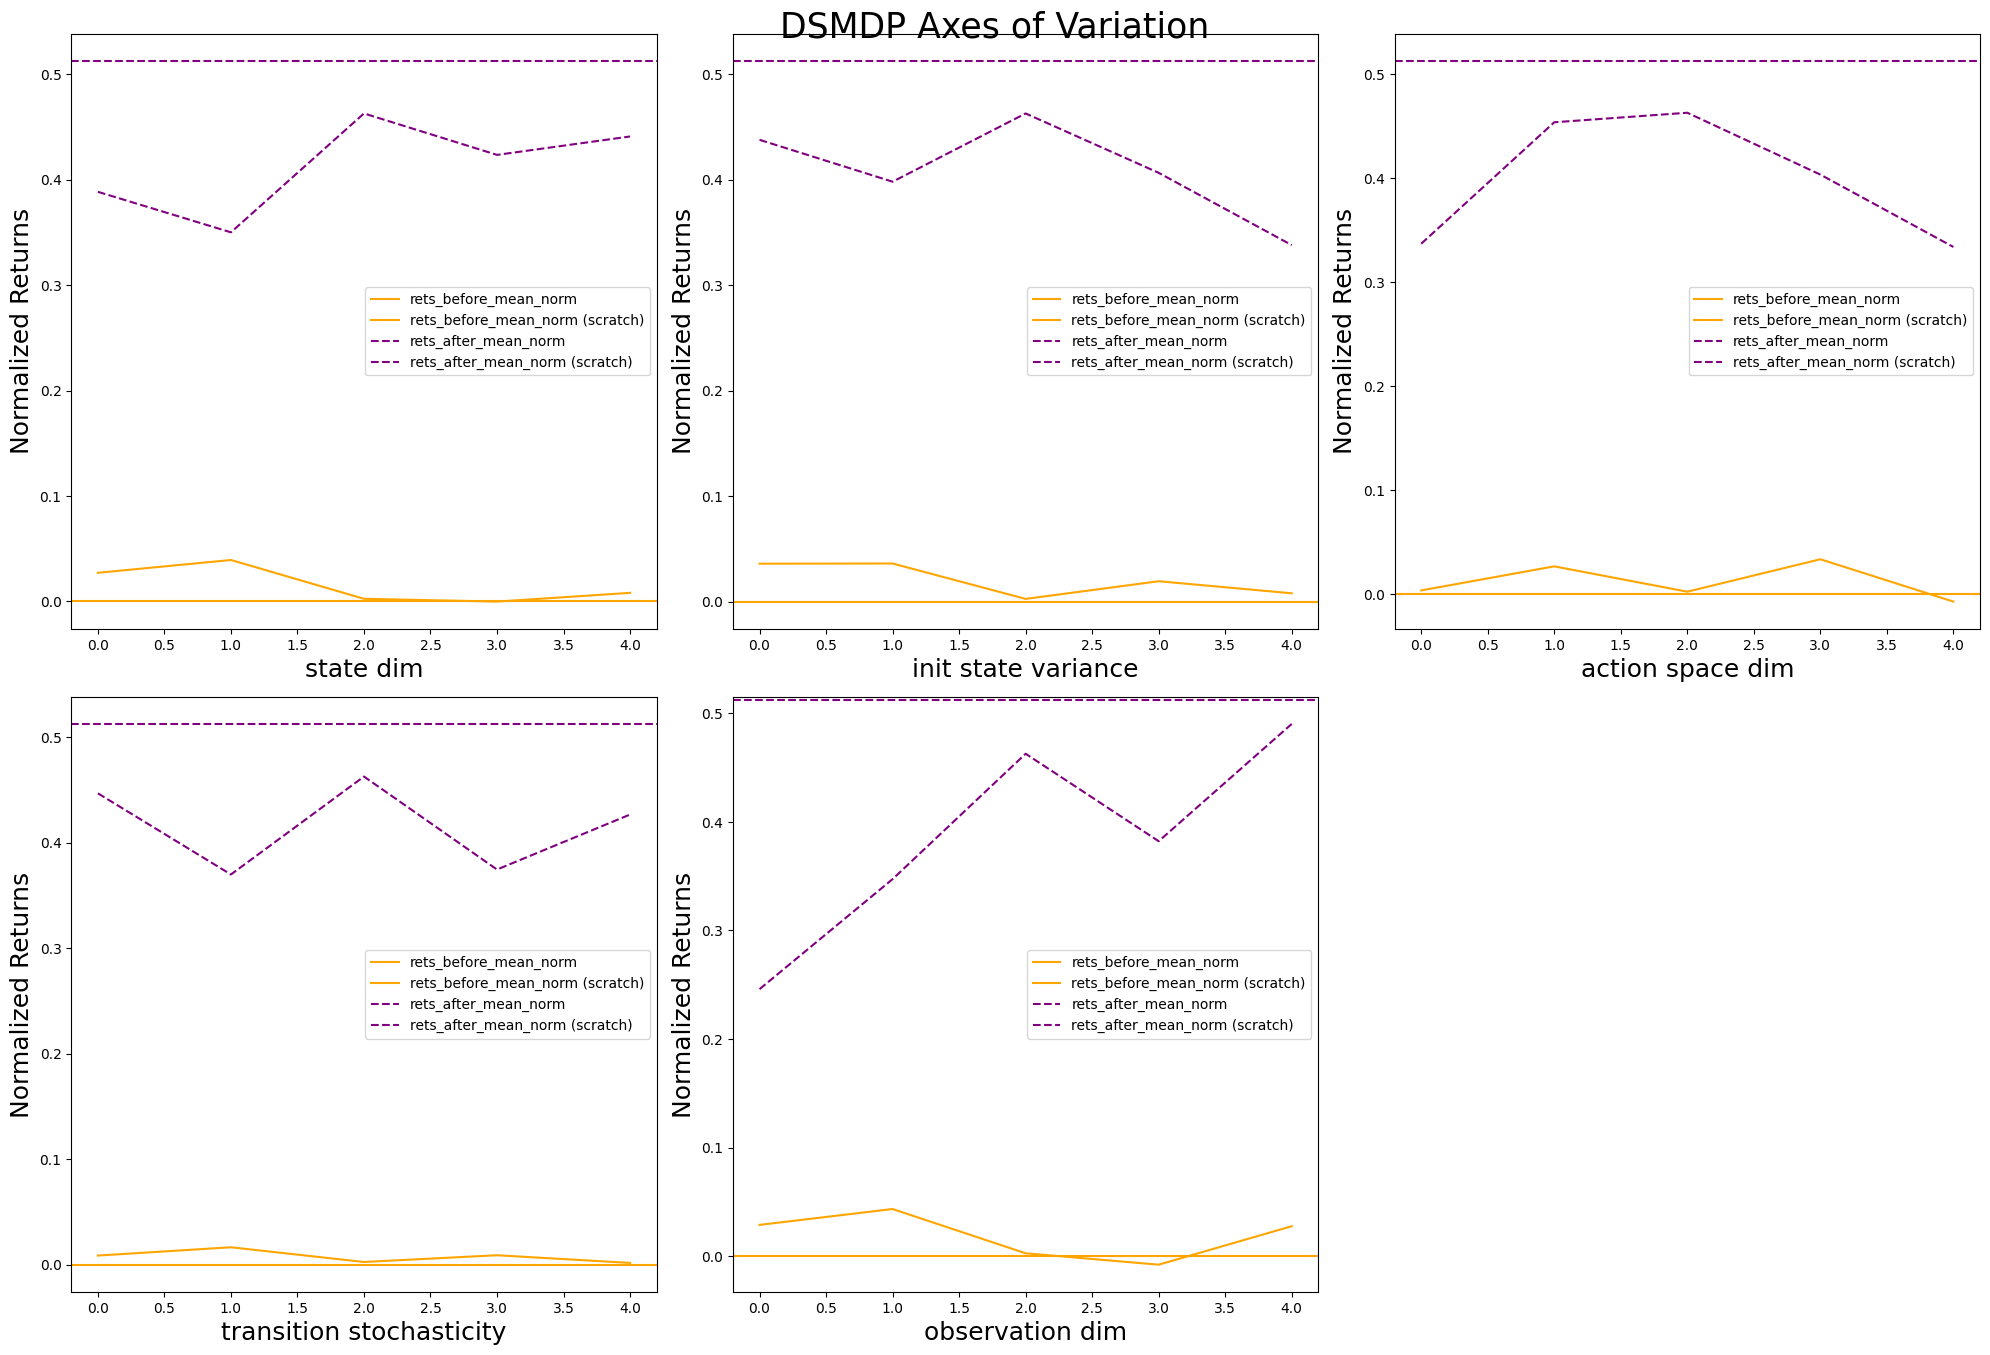

In [143]:
env_args_default = dict(i_d=2,i_s=2,t_a=2,t_s=2,o_d=2,tl=64)

arg2title = dict(i_d="state dim", i_s="init state variance", t_a="action space dim", t_c="transition complexity",
                 t_l="transition globality", t_s="transition stochasticity", o_d="observation dim", o_c="observation complexity", r_c="reward complexity")

plt.figure(figsize=(20, 20))
for i_plt, k in enumerate(env_args_default):
    if k=='tl':
        continue
    env_args = env_args_default.copy()
    env_ids = []
    for i in range(5):
        env_args[k] = i
        env_id = "name=dsmdp;"+";".join([f"{k}={v}" for k, v in env_args.items()])
        env_ids.append(env_id)

    # metrics = ['mse_act_before', 'mse_act_after', 'mse_obs_before', 'mse_obs_after']
    # cs = ['g', 'g', 'b', 'b']
    # linestyles = ['solid', '--', 'solid', '--']

    metrics = ['rets_before_mean_norm', 'rets_after_mean_norm']
    cs = ['orange', 'purple']
    linestyles = ['solid', '--']

    plt.subplot(3, 3, i_plt+1)
    for metric, c, ls in zip(metrics, cs, linestyles):
        plt.plot(np.arange(5), list(dfs[metric]['aggregate'].loc[env_ids]), c=c, linestyle=ls, label=metric)
    
        plt.axhline(dfs[metric]['aggregate'].loc['scratch'], c=c, linestyle=ls, label=f'{metric} (scratch)')
        
    plt.legend()
    plt.xlabel(arg2title[k], fontsize=18)
    plt.ylabel("Normalized Returns", fontsize=18)

plt.suptitle("DSMDP Axes of Variation", fontsize=25)
plt.tight_layout()
plt.show()
    

In [125]:
a = load_pkl("/vision-nfs/isola/env/akumar01/synthetic-mdps-data/icl_test/HalfCheetah/name=csmdp;i_d=2;i_s=2;t_a=2;t_c=2;t_l=4;t_s=2;o_d=2;o_c=2;r_c=2;tl=64_oracle_aug/", "rollout_data")
print(a[0]['rets'].mean())
print(a[-1]['rets'].mean())
a = load_pkl("/vision-nfs/isola/env/akumar01/synthetic-mdps-data/icl_test/HalfCheetah/scratch/", "rollout_data")
print(a[0]['rets'].mean())
print(a[-1]['rets'].mean())


-80.78117680549622
3997.624517917633
-67.55122172832489
4166.448492050171


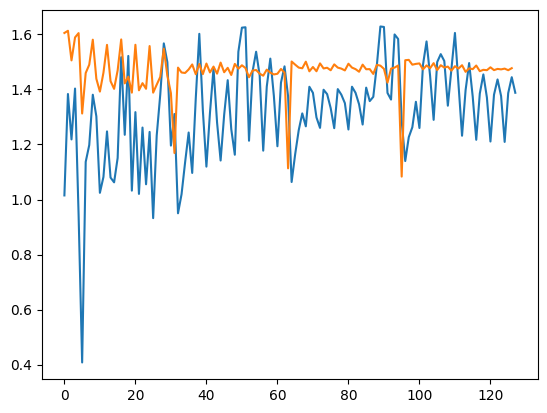

In [71]:
plt.plot(a['mse_act'][0])
plt.plot(a['mse_obs'][0])

In [221]:

def get_ppl(rng, N, temp):
    logits = jax.random.normal(rng, (1000, N))/temp
    log_p = jax.nn.log_softmax(logits, axis=-1)
    entr = (-jnp.exp(log_p)*log_p).sum(axis=-1)
    ppl = jnp.exp(entr)
    return ppl.mean()

Array([0.03162277, 0.1       , 0.31622776, 1.        , 3.1622777 ],      dtype=float32)

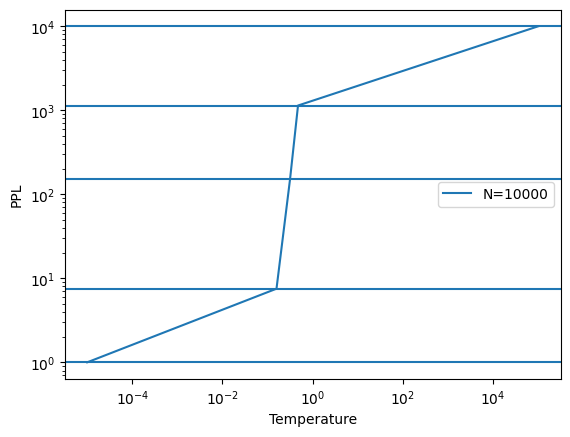

In [296]:
# temp = jnp.logspace(-1.5, .5, 5)
temp = jnp.array([1e-5, 1/10, np.sqrt(1/10), 1, 1e5])
temp = jnp.array([1e-5, .316/2, 0.316, .316*1.5, 1e5])


for N in [10000]:
    a = jax.vmap(partial(get_ppl, rng, N))(temp)
    plt.plot(temp, a, label=f'N={N}')
#     plt.axhline(N)
# plt.axhline(1)
    [plt.axhline(i) for i in a]

plt.legend()
plt.xlabel("Temperature")
plt.ylabel("PPL")
plt.yscale('log')
plt.xscale('log')
jnp.logspace(-1.5, .5, 5)

In [196]:
rng = jax.random.PRNGKey(0)
get_ppl(rng, 10, temp=0.3)

2.6189701557159424

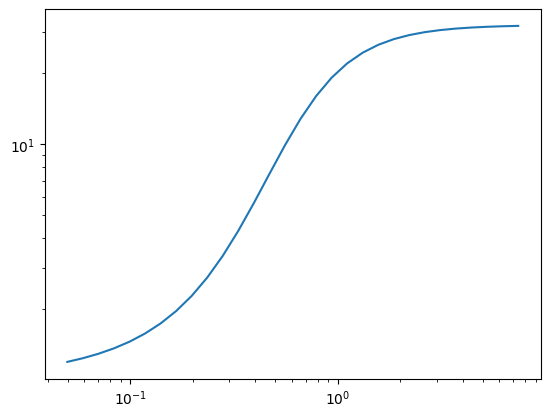

In [149]:
temp = jnp.exp(jnp.linspace(-3, 2, 30))
# temp = jnp.array([0.001, .1, .3, 1, 1000])
plt.plot(temp, jnp.exp(jax.vmap(get)(temp)))
plt.xscale('log')
plt.yscale('log')

In [148]:
from typing import Callable

In [188]:
class RandomMLP(nn.Module):
    n_layers: int
    d_hidden: int
    d_out: int
    activation: Callable

    @nn.compact
    def __call__(self, x, train=False):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.d_hidden, kernel_init=nn.initializers.normal(1),
                         bias_init=nn.initializers.normal(1))(x)
            x = nn.BatchNorm(use_running_average=not train, momentum=0., use_bias=False, use_scale=False)(x)
            x = self.activation(x)
            # x = nn.BatchNorm(use_running_average=not train, momentum=0., use_bias=False, use_scale=False)(x)
        x = nn.Dense(features=self.d_out, kernel_init=nn.initializers.normal(1), bias_init=nn.initializers.normal(1))(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0., use_bias=False, use_scale=False)(x)
        return x
        
def create_random_net_normal(rng, net, batch_size, d_in):
    _rng1, _rng2 = split(rng)
    x = jax.random.normal(_rng1, (batch_size, d_in))
    params = net.init(_rng2, x[0])
    y, updates = net.apply(params, x, train=True, mutable=['batch_stats'])
    params['batch_stats'] = updates['batch_stats']
    y = net.apply(params, x)
    # assert jnp.allclose(y.mean(axis=0), jnp.zeros_like(y.mean(axis=0)), atol=1e-2)
    # assert jnp.allclose(y.std(axis=0), jnp.ones_like(y.std(axis=0)), atol=1e-2)
    return params



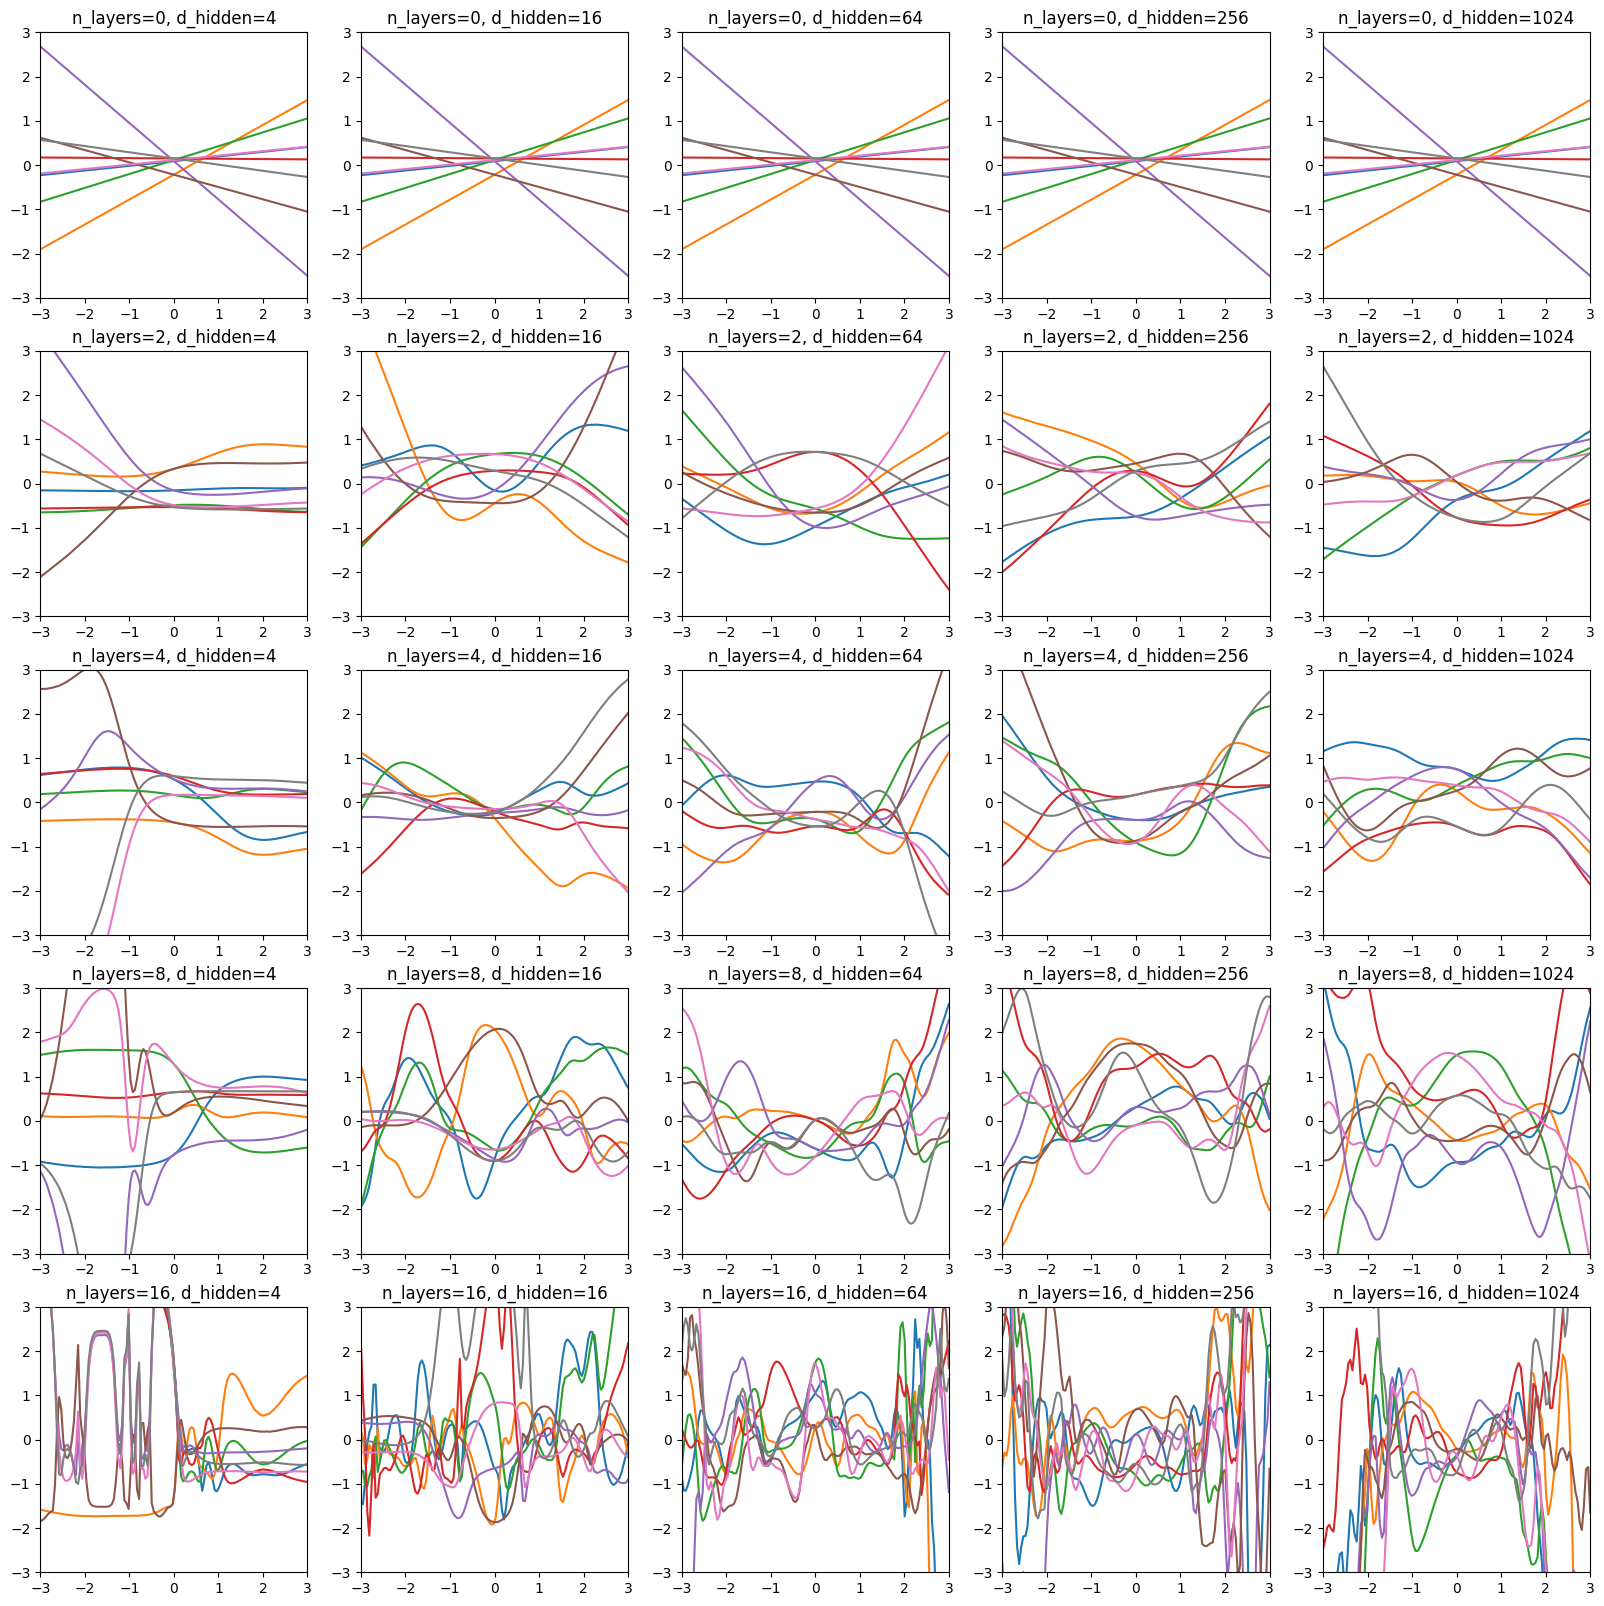

In [190]:
rng = jax.random.PRNGKey(0)

plt.figure(figsize=(20, 20))
for i1, n_layers in enumerate([0, 2, 4, 8, 16]):  
    for i2, d_hidden in enumerate([4, 16, 64, 256, 1024]):  
        plt.subplot(5, 5, i1*5+i2+1)
        d_in, d_out = 4, 4
        activation = nn.gelu
        net = RandomMLP(n_layers=n_layers, d_hidden=d_hidden, d_out=d_out, activation=activation)

        params = create_random_net_normal(rng, net, 32, d_in)
  
        t = jnp.linspace(-3, 3, 128)
        def get_nn_slice(rng):  
            rng, _rng = split(rng)  
            v = jax.random.normal(_rng, (d_in, ))  
            v = v/jnp.linalg.norm(v)  
            x = t[:, None] * v
            y = jax.vmap(net.apply, in_axes=(None, 0))(params, x)  
            y = rearrange(y, 't d -> d t')  
            return y  
   
        y = jax.vmap(get_nn_slice)(split(rng, 2))
        y = rearrange(y, 'b1 b2 t -> (b1 b2) t')  
        plt.plot(t, y.T)  
        plt.xlim(-3, 3)  
        plt.ylim(-3, 3)  
        plt.title(f'n_layers={n_layers}, d_hidden={d_hidden}')